In [2]:
import os
import time
import math
from random import randint
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import seaborn as sns
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = '../saved_models/unet_model.pth'

cuda


In [3]:
data_path = '../data/competition_data/'
test_imgs = pd.read_csv(data_path+'sample_submission.csv').id.values

# stratified spliting
train_df = pd.read_csv(data_path+'train.csv')

def load_mask(_id):
    mask_dir = data_path+'train/masks/'
    mask = cv2.imread(os.path.join(mask_dir, _id+'.png'))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)//255
    return mask.sum()

train_df['coverage'] = train_df.id.apply(load_mask)/pow(101, 2)
train_df['cuts'] = pd.cut(train_df.coverage, bins=10, labels=list(range(10)))
train_df = train_df.set_index('id')

#splits
def stratified_split(df, sample_percent=0.25, seed=42):
    grouped = df.groupby('cuts')
    samples = []
    for name, group in grouped:
        sample_size = int(group.shape[0]*sample_percent)
        samples.extend(list(group.sample(sample_size, random_state=seed).index))
    return samples

train_set = train_df.drop(stratified_split(train_df)).reset_index().id
val_set = train_df.loc[stratified_split(train_df)].reset_index().id

In [4]:
# Dataset to load images
class TGSDatasetAlbu(Dataset):
    def __init__(self, ids, image_path, mask_path, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        
        image_list= ids.values
        sample_names = []
        for img_name in image_list:
            sample_names.append(img_name+'.png')
            
        self.sample_names = sample_names
        
        self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
            
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_path, self.sample_names[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(os.path.join(self.mask_path, self.sample_names[idx]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image, mask

    def __len__(self):
        return len(self.sample_names)

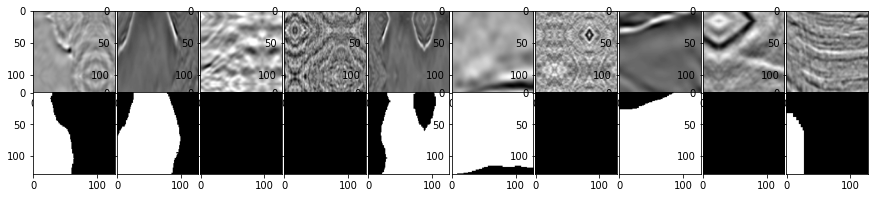

In [5]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(p=0.2, limit=0.2),
    A.RandomContrast(p=0.1, limit=0.2),
    A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=0, p=0.7),
    A.Resize(128, 128),
    A.ToFloat(always_apply=True),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(128, 128),
    A.ToFloat(always_apply=True),
    ToTensorV2()
])

downsize_transform = A.Compose([
    A.Resize(101, 101)
])

# Test dataset is working and see some samples
def sample(dataset, num_samples):
    samples = []
    for i in range(num_samples):
        n = randint(0, len(dataset))
        img, mask = dataset[n]
        samples.append((img.squeeze(), mask.squeeze()))
    return samples

dataset = TGSDatasetAlbu(val_set, data_path+'train/images', 
                         data_path+'train/masks', train_transform)
imgs = sample(dataset, 10)
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0, wspace=0)
offset = len(imgs)
for i in range(offset):
    ax = fig.add_subplot(2, offset, i+1)
    ax.imshow(imgs[i][0], cmap='gray')
    
    ax = fig.add_subplot(2, offset, i+1+offset)
    ax.imshow(imgs[i][1], cmap='gray')
    
plt.show()

In [6]:

import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, mode='min', path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.score_prev = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
        assert mode in ['max', 'min']
        if mode is 'max':
            self.multiple = 1
        else:
            self.multiple = -1
    def __call__(self, score, model):

        score = self.multiple*score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0

    def save_checkpoint(self, score, model):
        if self.verbose and self.multiple==-1:
            self.trace_func(f'Score decreased ({self.score_prev*self.multiple:.6f} --> {score*self.multiple:.6f}).  Saving model ...')
        elif self.verbose and self.multiple==1:
            self.trace_func(f'Score increased ({self.score_prev:.6f} --> {score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.score_prev = score
    
stopper = EarlyStopping(verbose=True, 
                        path='../saved_models/unet_model_best.pth', 
                        patience=15, mode='max')

In [9]:

def get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1,2))
    union = (A|B).float().sum((1,2))
    iou = (intersection + 1e-6)/(union + 1e-6)
    return iou
    
def train(model, x, y, loss_fn, optimizer):
    x, y = x.to(device), y.to(device)
    model.train()
    
    outputs = model(x)
    loss = loss_fn(outputs.squeeze(), y.bool().float())
    iou = get_iou_score(outputs, y).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item()

def validate(dataloader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        running_iou = []
        running_loss = []
        for x,y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out.squeeze(), y.bool().float())
            iou = get_iou_score(out, y).mean()
            running_iou.append(iou.item())
            running_loss.append(loss.item())
    return np.mean(running_loss), np.mean(running_iou)

def train_epochs(train_dataloader, val_dataloader, model, loss_fn, num_epochs):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True)
    steps = len(train_dataloader.dataset)//train_dataloader.batch_size
    lowest_loss = 10
    best_model = model

    start = time.time()
    train_losses = []
    train_ious = []
    val_losses = []
    val_ious = []
    for epoch in range(1, num_epochs+1):
        print('-'*10)
        print('Epoch {}/{}'.format(epoch, num_epochs))
        running_iou = []
        running_loss = []
        for step, (x, y) in enumerate(train_dataloader):
            loss, iou = train(model, x, y, loss_fn, optimizer)
            running_iou.append(iou)
            running_loss.append(loss)
            print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}'.format(100*(step+1)/steps, loss,iou), end = "")
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\t{}'.format(100*(step+1)/steps,np.mean(running_loss),np.mean(running_iou), timeSince(start)))
        print('running validation...', end='\r')
        val_loss, val_iou = validate(val_dataloader, model, loss_fn)
        print('Validation: \tloss {:8.4f} \tIoU {:8.4f}'.format(val_loss, val_iou))
        scheduler.step(np.mean(running_iou))

        train_losses.append(loss)
        train_ious.append(iou) 
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        
        stopper(val_iou, model)
        print(stopper.early_stop)
    
    return val_losses, val_ious, best_model

In [10]:
def init_model(from_scratch=True, path='unet_model.pth', best=False):
    model = smp.UnetPlusPlus(encoder_name='resnet34',
                   encoder_weights='imagenet',
                   in_channels=1,
                   classes=1).to(device)
    if from_scratch:
        print('Model initialised from Scratch.')
        return model 
    elif best:
        path = path.split('.')
        path[0] += '_best'
        path = '.'.join(path)
        model.load_state_dict(torch.load(path))
        print('Loaded saved model at: ', path)
        return model
    else:
        model.load_state_dict(torch.load(path))
        print('Loaded saved model at: ', path)
        return model

In [13]:
NUM_EPOCHS = 50
BATCH_SIZE = 128

train_dataset = TGSDatasetAlbu(train_set, data_path+'train/images', 
                               data_path+'train/masks', train_transform)
val_dataset = TGSDatasetAlbu(val_set, data_path+'train/images', 
                             data_path+'train/masks', validation_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

model = init_model(from_scratch=True, path=model_path)

loss_fn2 = smp.utils.losses.LovaszLoss(mode='binary')
loss_fn1 = nn.BCEWithLogitsLoss()


losses, ious, best_model = train_epochs(train_dataloader, val_dataloader, model, loss_fn1, NUM_EPOCHS)

# save model
torch.save(model.cpu().state_dict(), model_path)
print('model saved to: ', model_path)

Model initialised from Scratch.
----------
Epoch 1/50
 100.0 %	loss   0.4307	IoU   0.3538	0m 16s
Validation: 	loss   0.5420 	IoU   0.4785
Score increased (0.366099 --> 0.478545).  Saving model ...
False
----------
Epoch 2/50
 100.0 %	loss   0.3016	IoU   0.6071	0m 35s
Validation: 	loss   0.3979 	IoU   0.4123
EarlyStopping counter: 1 out of 15
False
----------
Epoch 3/50
 100.0 %	loss   0.2631	IoU   0.6633	0m 53s
Validation: 	loss   0.1878 	IoU   0.6445
Score increased (0.478545 --> 0.644470).  Saving model ...
False
----------
Epoch 4/50
 100.0 %	loss   0.2360	IoU   0.6666	1m 12s
Validation: 	loss   0.2772 	IoU   0.6389
EarlyStopping counter: 1 out of 15
False
----------
Epoch 5/50
 100.0 %	loss   0.2184	IoU   0.7043	1m 31s
Validation: 	loss   0.1540 	IoU   0.7290
Score increased (0.644470 --> 0.728959).  Saving model ...
False
----------
Epoch 6/50
 100.0 %	loss   0.2065	IoU   0.7252	1m 50s
Validation: 	loss   0.1883 	IoU   0.6989
EarlyStopping counter: 1 out of 15
False
----------
Epo